In [1]:
# Inflow entrainment
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import gsw

In [2]:
# Find the interface
def Layer(u):
    # Layer interface, zero velocity crossing point
    uzx = u.mean(axis=(0,2)) # Z, X
    X = uzx.shape[1]
    itf = np.empty(X, dtype=int)
    itf[[0,1,-2,-1]] = 0 # Remove data at fjord head and end
    for i in range(2,X-2):
        l = np.where(uzx[:, i] < 0)[-1][0]
        itf[i] = l
    return itf

In [31]:
def QR(sd):
    state01 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/Sills/state_' + str(format(sd,'03d')) + '.nc')
    state02 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/Sills/grid_' + str(format(sd,'03d')) + '.nc')
    #state03 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/Sills/Diagnostics/icefrntT_' + str(format(sd,'03d')) + '.nc')
    state1 = state01.isel(Y=range(1,10), T=range(40,121))
    
    
    u = state1.U.data
    w = state1.W.data
    #icefrntT = state03.icefrntT.data[39:,:,5,1] # Plume temperature at the front
    drF = state02.drF.data
    Area = np.empty([50, 9]) # Cross Y direction
    Area[:10, :] = 100
    Area[10:20, :] = 200
    Area[20:30, :] = 300
    Area[30:40, :] = 800
    Area[40:, :] = 1600

    f = 52 # section index starting from the sill slope 52
    s = 66-f  # section index at the sill
    Ls = state1.Xp1.data[66] - state1.Xp1.data[f] # Entrainment zone horizontal scale
    CellVol = state02.rA.data[None,1:-1,:] * state02.drF.data[:,None,None] * state02.HFacC.data[:,1:-1,:]
    Temp = state1.Temp.data.mean(0)
    
    itf = Layer(u)
    L = len(itf)-2 # exclude the open boundary at the fjord end
    it = itf[f:]
    ut = u[:,:,:,f:].mean(0)
    wt = w[:,:,:,f:].mean(0)
    HFacW = state02.HFacW.data[:,1:-1,f:] # vertical fraction of open cell at West face
    drF = state02.drF.data
    
    rA = state02.rA.data[1:-1,f:] # r face area at cell center   

    Vx1 = np.empty(L-f) # Horizontal volume transport for the upper layer
    Vx2 = np.empty(L-f) # Horizontal volume transport for the lower layer
    Vz = np.empty(L-f) # Vertical volume transport through the interface
    u2 = np.empty(L-f)
    h2 = np.empty(L-f)
    for i in range(L-f):
        Vx1[i] = np.sum(ut[:it[i],:,i] * HFacW[:it[i],:,i] * Area[:it[i],:])
        Vx2[i] = np.sum(ut[it[i]:,:,i] * HFacW[it[i]:,:,i] * Area[it[i]:,:])
        Vz[i] = np.sum(wt[it[i],:,i] * rA[:,i])
        gh = HFacW[:,:,i].mean(1) * drF
        h2[i] = sd - np.sum(gh[:it[i]])
        u2[i] = np.sum(ut[it[i]:,:,i].mean(1) * gh[it[i]:]) / h2[i]
        #u2[i] = ut[it[i],:,i].mean()
       
    Qr = Vx1[0] - Vx1[s] # Recirculation
    Q1 = 4900 - Vx1[s]
    U2 = -u2[s]
    Q2 = Vx1[0]
    hr = h2[s] / sd
    Qw = -Vz[:s].sum()
    return (Q1, Qr, Qw, hr)

In [27]:
Q1, Qr, U2, hr = QR(22)
Q1, Qr

(496.5056573972106, 170.34946158528328)

In [6]:
def BulkFroude(Hs):
    file = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/Sills/state_' + str(format(Hs,'03d')) + '.nc')
    grid = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/Sills/grid_' + str(format(Hs,'03d')) + '.nc')
    state = file.isel(Y=range(1,10), T=range(40,len(file.T)))
    depth = state.Z.data
    xdis = state.X.data
    #gh = np.repeat(np.array([[.5],[1],[1.5],[4],[8]]),10) # Grid height 
    drF = grid.drF.data # r cell face separation
    pres = gsw.p_from_z(depth, 0)
    pt = state.Temp.data.mean(axis=(0,2)) # Y-axis average
    s = state.S.data.mean(axis=(0,2))
    P = np.tile(pres,[len(xdis),1]).T
    rho = gsw.rho(s, pt, P)
    
    u0 = state.U.data # dims = T, Z, Y, Xp1
    u_x = (u0[:, :, :, 1:] + u0[:, :, :, :-1]) / 2 # Convert the value to grid center in x direction
    u = u_x.mean(axis=(0,2)) # dims = Z, X
    #u[u==0] = np.nan
       
    Fr1 = np.empty(len(xdis))
    Fr2 = np.empty(len(xdis))
    U1 = np.empty(len(xdis))
    U2 = np.empty(len(xdis))
    H2 = np.empty(len(xdis))
    Gr = np.empty(len(xdis))
    N = np.empty(len(xdis))
    Mix = np.empty(len(xdis))
    Fr1[[0,-1]] = np.nan
    Fr2[[0,-1]] = np.nan
    U1[[0,-1]] = np.nan
    U2[[0,-1]] = np.nan
    H2[[0,-1]] = np.nan
    Gr[[0,-1]] = np.nan
    N[[0,-1]] = np.nan
    Mix[[0,-1]] = np.nan
    for i in range(1,len(xdis)-1):           
        p = np.where(u[:,i] < 0)[-1][0]
        gh = grid.HFacC.data[:,1:10,i].mean(1) * drF
        h1 = gh[:p].sum()
        u1 = np.sum(u[:p,i] * gh[:p] / h1) 
        rho1 = np.sum(rho[:p,i] * gh[:p] / h1)
        s1 = np.sum(s[:p,i] * gh[:p] / h1)
        
        if sum(j < 0 for j in u[p:,i]) == len(gh)-p:
            n = len(gh) - p
        else:    
            n = np.where(u[p:,i] >= 0)[-1][0]
            
        h2 = gh[p:p+n].sum()
        u2 = np.sum(u[p:p+n,i] * gh[p:p+n] / h2)
        rho2 = np.sum(rho[p:p+n,i] * gh[p:p+n] / h2)
        s2 = np.sum(s[p:p+n,i] * gh[p:p+n] / h2)
        N2array, Parray = gsw.stability.Nsquared(s[:p+n,i], pt[:p+n,i], P[:p+n,i])
        N[i] = N2array.mean()
        Mix[i] = s2 / (s2 - s1)
        g = 9.8 * (rho2-rho1) / rho2
        Fr1[i] = u1 ** 2 / (g * h1)
        Fr2[i] = u2 ** 2 / (g * h2)
        U1[i] = u1
        U2[i] = u2
        H2[i] = h2
        Gr[i] = np.sqrt(g*h2)
        
    h = H2[65]
    U = U2[65]
    Ri = Gr[65] * h / ((U1[65]-U2[65])**2)
    cos = 600 / np.sqrt(600**2 + (150-Hs)**2)
    s = (150-Hs) / np.sqrt(600**2 + (150-Hs)**2)
    Cd = 2.5e-3
    FrB = Fr2[65] / cos
    #ug = np.cbrt(Gr[65]*h*U*s/Cd)
    ug = np.sqrt(Gr[65]*h)
    ns = N[65]
    B = U*h*1800*(ns**1.5)/(Gr[65]**2)
    return (ug, h, Mix)

In [ ]:
file = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/Sills/state_' + str(format(20,'03d')) + '.nc')
state = file.isel(Y=range(1,10), T=range(40,len(file.T)))
depth = state.Z.data
xdis = state.Xp1.data
u = state.U.data.mean(axis=(0,2))
state.X.data[65]

In [32]:
H = 150
L = 600 # Slope width of the sill
W = 1800 # Fjord width
Hs = np.array([8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22]) # Sill depth [8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 30, 110, 150]

tan = (H-Hs) / L
cos = L / np.sqrt(L**2 + (H-Hs)**2)
sin = (H-Hs) / np.sqrt(L**2 + (H-Hs)**2)
#ns, h, Ri = BulkFroude(13)
Q1, Qr, U2, Ls = QR(10)
U, h, P = BulkFroude(150)
#P[1:-1].mean(), P, Q1

/Users/weiyangbao/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in double_scalars


In [ ]:
fig1, ax =plt.subplots(figsize=(10,7))

Re = np.empty(len(Hs))
We = np.empty(len(Hs))
R = np.empty(len(Hs))
for j in range(len(Hs)):
    Q2, Qr, U2, Ls = QR(Hs[j])
    U, h, mix = BulkFroude(Hs[j])
    R[j] = U * np.sqrt(sin[j]/2.5e-3)
    Re[j] = Qr
    #We[j] =  np.sqrt(L**2+(H-Hs[j])**2)
    We[j] = U2 * 0.071 * W * (H-Hs[j])
      
#ax.set(xlim=(3200, 5500), ylim=(3200, 5500))
ax.set(xlim=(0, 3800), ylim=(0, 3800))
plt.axis('square')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$Q_r (m^3/s)$', size=20)
plt.ylabel(r'$Q_e (m^3/s)$', size=20)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.plot(Re, We, 'o-', lw=2, label=r'$\frac{Q_r}{Q_oc}$')
#ax.plot(r, Tin_f-Tout_f, 'o-', lw=2, label='dT')
#ax.legend(loc = 'best', fontsize=15)
We

/Users/weiyangbao/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in double_scalars


(array([3741.2102839 , 3553.40547233, 3277.2259824 , 2852.67368238,
        2434.92042236, 2176.30925886, 1863.03515448, 1729.45795641,
        1480.90355191, 1047.76264066,  632.09542762,  170.34946159]),
 array([3133.42631366, 2909.29632157, 2707.81862959, 2533.85390174,
        2271.91459499, 2097.07044736, 1862.34108682, 1775.53686048,
        1595.81361227, 1209.34764221,  852.6419308 ,  496.5056574 ]))

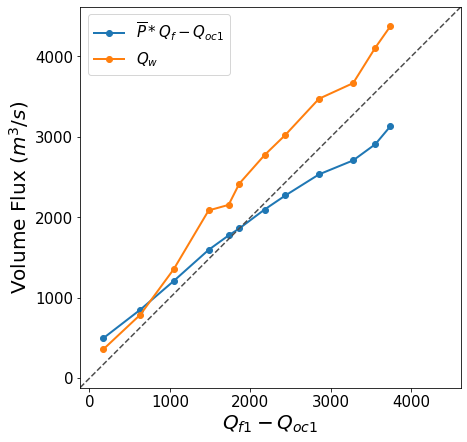

In [43]:
fig2, ax =plt.subplots(figsize=(10,7))
Qf = 700
r = Hs / H
Pfac = np.empty(len(Hs))
Q1 = np.empty(len(Hs))
QW = np.empty(len(Hs))
R =  np.empty(len(Hs))
for k in range(len(Hs)):
    Q, Qr, Qw, Ls = QR(Hs[k])
    Q1[k] = Q
    QW[k] = Qw
    R[k] = Qr
    
      
ax.set(xlim=(100, 4400), ylim=(100, 4400))
plt.axis('square')   
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xlabel(r'$\frac{H_s}{H}$', size=20)
plt.xlabel(r'$Q_{f1}-Q_{oc1}$', size=20)
plt.ylabel(r'Volume Flux ($m^3/s$)', size=20)
ax.plot(R,Q1, 'o-', lw=2, label='$\overline{P}*Q_{f}-Q_{oc1}$')
ax.plot(R,QW, 'o-', lw=2, label='$Q_{w}$')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.legend(loc = 'best', fontsize=15)
#ax.axhline(y=4900,color='k',linestyle=':')
#ax.axhline(y=Q1.mean(),color='r',linestyle='--')
#ax.plot(r, Tin_f-Tout_f, 'o-', lw=2, label='dT')
#ax.legend(loc = 'best', fontsize=15)
R, Q1

In [44]:
fig_path = "/Users/weiyangbao/Documents/Jupyter_Figs/Transport/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig2.savefig(fig_path + '/Recir.png', dpi = 150, bbox_inches='tight')